# ETL (PYTHON + SQL)

Поключаемся к ClickHouse через Python c использованием библиотеки pandahouse. 

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Проверка соединения: 
Число строк в таблице

In [4]:
query = """
SELECT count()
FROM default.ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,count()
0,85207


In [5]:
# ДРУГОЙ СПОСОБ
int(ph.execute(query, connection_default))

85207

Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:
- price – цена за ночь
- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.
В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room. 

In [6]:
query = """
SELECT 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    room_type,
    id  
FROM ldn_listings
ORDER BY id ASC 
LIMIT 1000
"""
price = ph.read_clickhouse(query, connection=connection_default)
price.head()

,price,room_type,id
0,65.0,Private room,13913
1,100.0,Entire home/apt,15400
2,300.0,Entire home/apt,17402
3,150.0,Private room,17506
4,65.0,Entire home/apt,25023


In [7]:
price.groupby('room_type').quantile(q=0.75) 

,price,id
room_type,,
Entire home/apt,160.00,463610.50
Hotel room,157.00,73302.50
Private room,70.00,453442.50
Shared room,69.25,472261.75


К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). 
В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга 

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)


In [8]:
query = """
SELECT  
    room_type,
    avg(price) as avg_price,
    avg(review_scores_rating) as avg_review_scores_rating
FROM  
    (
    SELECT 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        room_type,
        toFloat32OrNull(review_scores_rating) AS review_scores_rating
    FROM ldn_listings
    WHERE review_scores_rating != 0
    ORDER BY id ASC 
    LIMIT 1000
    )
GROUP BY room_type
"""
mean_scores = ph.read_clickhouse(query, connection=connection_default)
mean_scores.head()

,room_type,avg_price,avg_review_scores_rating
0,Hotel room,134.000000,92.500000
1,Private room,54.642436,94.766208
2,Shared room,21.000000,90.000000
3,Entire home/apt,135.882957,93.568789


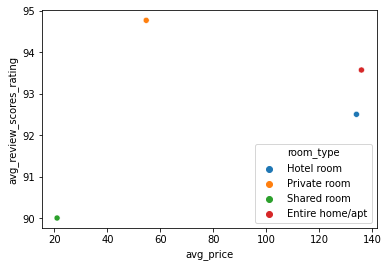

In [9]:
sns.scatterplot(data=mean_scores, x='avg_price', y='avg_review_scores_rating', hue='room_type')

Помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.
Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

- host_id – идентификатор хозяина (уникальный)
- host_verifications – какими способами хост подтвердил свой профиль

Затем обработайте столбец host_verifications:

В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). 
Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']


Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [10]:
query = """
SELECT  
    DISTINCT host_id,
    host_verifications
FROM   
    ldn_listings
WHERE experiences_offered != 'none'
"""

verifications = ph.read_clickhouse(query, connection=connection_default)
verifications

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook'] 

Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?


In [11]:
verifications.host_verifications = verifications.host_verifications.apply(lambda x: x.strip('[]').split(', '))
verifications.host_verifications.explode(ignore_index=True).value_counts()

'phone'                    1361
'email'                    1345
'reviews'                  1309
'government_id'            1196
'jumio'                    1115
'offline_government_id'     469
'work_email'                279
'facebook'                  270
'selfie'                    252
'identity_manual'           227
'manual_offline'             70
'google'                     34
'kba'                        27
'manual_online'              16
'sent_id'                     6
Name: host_verifications, dtype: int64

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 

Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.
Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. 

Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. 

Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 


In [12]:
query = """
SELECT  
    neighbourhood_cleansed,
    experiences_offered,
    count(*) AS experiences_count
FROM   
    ldn_listings
WHERE experiences_offered != 'none'
GROUP BY 
    neighbourhood_cleansed,
    experiences_offered
ORDER BY experiences_count DESC 
LIMIT 100  
"""


experiences = ph.read_clickhouse(query, connection=connection_default)
experiences

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [13]:
experiences = experiences.pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values = 'experiences_count')

In [14]:
experiences = experiences.fillna(0)

In [15]:
experiences.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,0.0,4.0


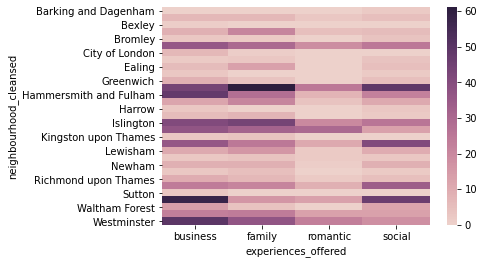

In [16]:
sns.heatmap(experiences, cmap=sns.cubehelix_palette(as_cmap=True))

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:
- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- price – цена за ночь 
- experiences_offered – вид доступного впечатления (оставить не 'none')

Далее постройте два графика, используя distplot из библиотеки seaborn:

- На первом отобразите исходные распределения цен для каждого типа жилья
- На втором – логарифмированные значения (np.log())

In [17]:
query = """
SELECT  
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE experiences_offered != 'none'
"""

price_room = ph.read_clickhouse(query, connection=connection_default)
price_room['log_price'] = np.log(price_room.price)

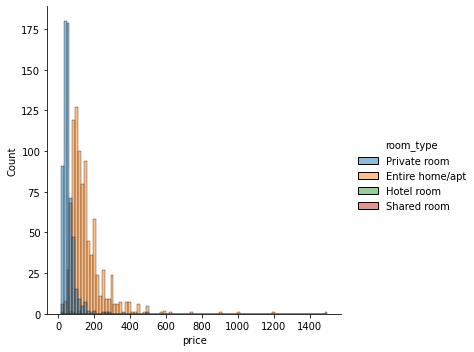

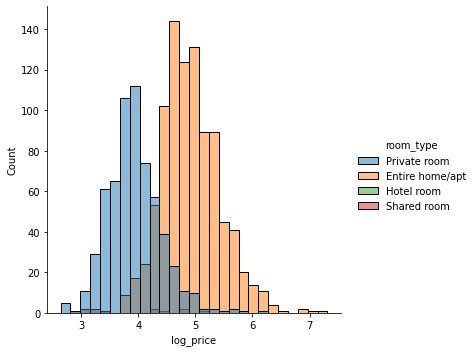

In [18]:
sns.displot(x='price', data = price_room, hue = 'room_type')
sns.displot(x='log_price', data = price_room, hue = 'room_type')

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- price – цена за ночь
- first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение поставьте на 1000 строк.


Используя sns.lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции .

 

In [19]:
query = """
SELECT  
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toDateOrZero(first_review) AS first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000 
"""

r = ph.read_clickhouse(query, connection=connection_default)
r.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [20]:
r['year_review'] = r.first_review.dt.year

In [21]:
r.head()

,room_type,price,first_review,year_review
0,Private room,65.0,2010-08-18,2010
1,Entire home/apt,300.0,2011-03-21,2011
2,Entire home/apt,65.0,2016-03-05,2016
3,Private room,29.0,2010-04-14,2010
4,Private room,100.0,2010-10-16,2010


In [22]:
r = r.groupby(['room_type', 'year_review']).agg({'price' : 'mean'})

In [23]:
r

price
room_type       year_review            
Entire home/apt 2010         103.500000
                2011         128.792450
                2012         135.467255
                2013         137.887634
                2014         154.583328
                2015         159.380951
                2016          99.733330
                2017         111.666664
                2018         125.066666
                2019         301.666656
                2020          50.000000
Hotel room      2010          88.000000
                2017         180.000000
Private room    2010          56.428570
                2011          52.607143
                2012          53.269840
                2013          57.036587
                2014          56.842106
                2015          48.058823
                2016          57.307693
                2017          51.142857
                2018          55.416668
                2019          74.000000
                2020          39.000000
Shared room     2012          22.000000
                2014          20.000000

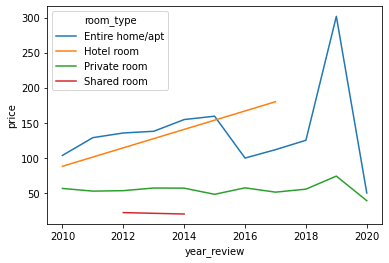

In [24]:
# Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) 
# в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X).
sns.lineplot(data=r, x='year_review', y = 'price', hue = 'room_type')